# Classification of fraudulent credit card transactions

In this exercise, we are predicting [credit card fraud](https://www.kaggle.com/mlg-ulb/creditcardfraud/home).

In [1]:
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Importing the data ##

Let's have a look at the data first.

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

The data consists of a number of variables [which are described on Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). There are 28 "secret" variables, plus *Time* (when was the transaction) and *Amount*. We can use them all. We are predicting *Class*: was the transaction fraudelent (1) or not (0). Let's see how many fraudulent cases there are.


In [50]:
df['Class'].value_counts()

0    99776
1      223
Name: Class, dtype: int64

There are a lot more non-fraud cases than fraud cases. 99.8% is genuine. So the difficulty will be in detecting fraud, not in detecting non-fraud. We can even get 99.8% accuracy by claiming everything is genuine (a really simple "model")!  Therefore, we will need to rely heavily on precision/recall when evaluating. This is a good example of the fact that just calculating accuracy is not enough for many problems.

Let's get our *X* and *y* and split the data.

In [3]:
X = df.loc[:,'Time':'Amount'] #This gets all the columns from Time to Amount
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


## Training the algorithm ##

Let's train the Random Forest algorithm. RF uses randomness, so we need to set a *random_state* if we want the result to be stable for presentation purposes.

I've also set the number of trees (*n_estimators*) to 100. This will become the default number of trees in the future of the *sklearn* package, since current literature suggests using more trees than was used traditionally (10). Also, computing power has increased (more trees require more computing power). The following might take half a minute or so to run, depending on your machine.

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1, n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
rf = rf.fit(X_train, y_train)

In [10]:
rf.score(X_test,y_test)

0.9994666666666666

## Evaluating the model ##

Let's evaluate the model using our standard approach for a *classification* problem: making a confusion matrix and calculating accuracy, precision and recall.

The confusion matrix uses the *sorted* labels, so 0 comes first, 1 second.

In [12]:
rf.classes_

array([0, 1], dtype=int64)

In [17]:
y_pred = rf.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
cm = pd.DataFrame(cm, index=['no fraud (actual)', 'fraud (actual)'], columns = ['no fraud (pred)', 'fraud (pred)']) #label and make df
cm

no fraud (pred)  fraud (pred)
no fraud (actual)            29933             1
fraud (actual)                  15            51

In [14]:
51/52

0.9807692307692307

As we can see from the confusion matrix, fraud is detected reasonably well. Let's calculate some numbers. Since you already learned how to calculate precision and recall by hand, now we're going to do it the easy way using a function called *classification_report*.

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29934
           1       0.98      0.77      0.86        66

    accuracy                           1.00     30000
   macro avg       0.99      0.89      0.93     30000
weighted avg       1.00      1.00      1.00     30000



The precision for fraud is very good (very close to 1): only about 2% of the suspected fraud cases turn out not to be fraud.

The recall is acceptable, but a bit low. We still miss about 23% of the fraud cases.

There is usually a trade-off between precision and recall. Think of it as the police: if you arrest only the people you _know 100% sure_ are criminals, you will catch only criminals (high precision), but only a few (low recall). If on the other hand you arrest people you suspect only slightly, you will catch a lot of innocent people (low precision), but all the criminals (high recall).

Though I'm not an expert on credit card fraud, I think a bank can afford a bit lower precision (checking more transactions by hand) to catch more fraud cases.

## Different parameters ##

We can change different parameters of the Random Forest algorithm. For instance, the number of trees (*n_estimators*) and the number of variables considered at each branch of a tree (*max_features*). *n_estimators* is by default set to 10 (soon 100) and *max_features* to the square root of the number variables (in this case 5). Let's change both drastically by using a single tree with all variables, and see what happens.

In [19]:
rf_new  = RandomForestClassifier(n_estimators = 1, max_features = 30, random_state=1) #RF is a random algorithm, so to get the same results we need to use random_state
rf_new = rf_new.fit(X_train, y_train)
y_pred_new = rf_new.predict(X_test) #the predicted values
print(classification_report(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29934
           1       0.73      0.77      0.75        66

    accuracy                           1.00     30000
   macro avg       0.86      0.89      0.87     30000
weighted avg       1.00      1.00      1.00     30000



The recall is similar, but the precision really suffers.

Obviously, just randomly thinking of numbers for parameters is not the way to go. You can tweak it manually, or, if you're interested, check out tutorials online such as [this one](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) for more complex solutions.

## Making use of probabilities ##

We saw that recall is probably the most important measure in this case. We also saw that there is a trade-off between precision and recall. So can we improve recall at the expense of precision?

Yes, it turns out we can. What actually happens "under the hood" of the algorithm, is that a probability is calculated. The algorithm then classifies cases according to this probability. The standard setting is to select the outcome with the highest probability. But, we can also work with the probabilities themselves.

Let's get the probabilities using *predict_proba*. Note that I'm using the first RF model again.

In [62]:
y_pred_prob = rf.predict_proba(X_test) #Instead of classes, we now get the probabilities
y_pred_prob


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

This is a two-dimensional array, with probabilities for not-fraud (first number) and fraud (second number). The first is almost always 1 (most are certainly not-fraud) and the second is almost always 0 (very few are suspected fraud). But not always. Let's visualize the probabilities to see. 

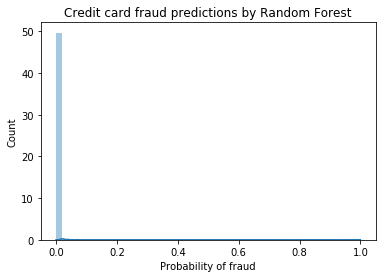

In [63]:
fraud_prob = y_pred_prob[:,1] #this subsets the second column (fraud)
sns.distplot(fraud_prob)
plt.xlabel("Probability of fraud")
plt.ylabel("Count")
plt.title("Credit card fraud predictions by Random Forest")
plt.show()

Hmm, that's not very helpful. Almost all probabilities are 0, so that's not very informative. Let's show only the ones above 0.01.

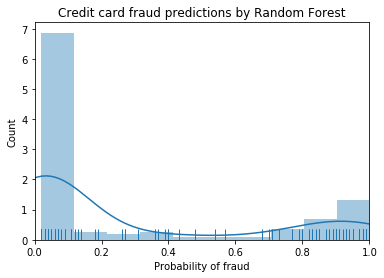

In [64]:
sns.distplot(fraud_prob[fraud_prob > 0.01], bins=10, rug=True)
plt.xlim(0,1)
plt.xlabel("Probability of fraud")
plt.ylabel("Count")
plt.title("Credit card fraud predictions by Random Forest")
plt.show()

Interestingly, the distribution is bimodal. Some of the cases are a bit suspect, and others are very suspect. There are not many cases in between.

We can now use a different cut-off for our fraud detection, and calculate new accuracy, precision and recall measures. This is left as an exercise for the reader.